## Installations

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import load_model
from imutils import paths
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import shutil
import os

## Helper Variables & Functions

In [1]:
ORIG_INPUT_DATASET = "House_Room_Dataset/Bedroom"

TRAIN = "training"
TEST = "evaluation"
VAL = "validation"

BASE_PATH = "dataset"
BATCH_SIZE = 32
CLASSES = ["Modern", "Old"] # "Neutral", 

In [3]:
def plot_hist(hist, metric):
    if metric == 'auc':
        plt.plot(hist.history["auc"])
        plt.plot(hist.history["val_auc"])
    else:
        plt.plot(hist.history["loss"])
        plt.plot(hist.history["val_loss"])
    plt.style.use("ggplot")
    plt.title("model {}".format(metric))
    plt.ylabel("{}".format(metric))
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

## Loading lables

In [4]:
with open("labels.txt", 'r') as f:
    manual_labels = f.read()
    
labels = [i for i in manual_labels]
len(labels)

451

In [5]:
from collections import Counter

print(Counter(labels).keys()) # equals to list(set(words))
print(Counter(labels).values()) # counts the elements' frequency

dict_keys(['O', 'M'])
dict_values([271, 180])


## Train-Test-Val Split

In [6]:
# Important to sort the files in the order in which we see them in folder
files = os.listdir(ORIG_INPUT_DATASET)
files.sort(key=lambda f: int(f.split('_')[1].split('.')[0]))

In [7]:
# splitting files into train and test sets
trainX, testX, trainY, testY =  train_test_split(files[:len(labels)], labels, stratify=labels, train_size=0.90)

In [8]:
# further splitting of train set into train and val sets
trainX, valX, trainY, valY = train_test_split(trainX, trainY, stratify=trainY, train_size=0.85)

In [9]:
len(trainX), len(trainY), len(valX), len(valY),  len(testX), len(testY)

(344, 344, 61, 61, 46, 46)

## Directory structure for batch processing


In [10]:
# Building the dataset properly - 
splits = [(trainX, trainY), (testX, testY), (valX, valY)]
dirnames = ['training', 'evaluation', 'validation']

for i, (data,label) in enumerate(splits):
    outside_dir=dirnames[i]

    for j in tqdm(range(0, len(label)), desc="Iterating over images in sub folder"):
        dir = label[j]
        
        # construct the path to the sub-directory
        dirPath = os.path.join(BASE_PATH, outside_dir, dir)
        
        # if the output directory does not exist, create it
        if not os.path.exists(dirPath):
            os.makedirs(dirPath)
            
            
        # copy the img to this new directory
        src_img = os.path.join(ORIG_INPUT_DATASET, data[j])
        shutil.copy(src_img, dirPath)

Iterating over images in sub folder: 100%|██████████| 61/61 [00:00<00:00, 156.07it/s]


In [11]:
# derive the paths to the training, validation, and testing directories
trainPath = os.path.sep.join([BASE_PATH, TRAIN])
valPath = os.path.sep.join([BASE_PATH, VAL])
testPath = os.path.sep.join([BASE_PATH, TEST])


In [12]:
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(trainPath)))
totalVal = len(list(paths.list_images(valPath)))
totalTest = len(list(paths.list_images(testPath)))


In [13]:
print(totalTrain, totalTest, totalVal)

344 46 61


# Data Augmentation

In [14]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=90,
	zoom_range=[0.5, 1.0],
	width_shift_range=0.3,
	height_shift_range=0.25,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest",
 	brightness_range=[0.2, 1.0]
   )

In [15]:
# Default for all the above parameters is 0, 
# meaning we are applying no augmentation to val set
# which is exactly what we need because val set should be treated like test set.
valAug = ImageDataGenerator()

In [16]:
testAug = ImageDataGenerator()

### Data Generators

In [17]:
# Create batches whilst creating augmented images on the fly

trainGen = trainAug.flow_from_directory(
    directory=trainPath,
    target_size=(224,224),
    save_to_dir='dataset/augmented/train',
    save_prefix='train',
    shuffle=True # data will be shuffled between epochs
)

Found 344 images belonging to 2 classes.


In [18]:
valGen = valAug.flow_from_directory(
    directory=valPath,
    target_size=(224,224),
    shuffle=True
)

Found 61 images belonging to 2 classes.


In [19]:
testGen = testAug.flow_from_directory(
    directory=testPath,
    target_size=(224,224),
    shuffle=False
)

Found 46 images belonging to 2 classes.


### Transfer Learning
##### Feature Extraction Step

In [20]:
def build_model():
    # Building the original base EfficientNet-0 model
    baseModel = EfficientNetB0(weights="imagenet", 
                  include_top=False, # make sure top layer i.e. head is not included
                  input_tensor=Input(shape=(224, 224, 3)),
                  pooling="avg"
                  )
    
    # freeze the weights
    for layer in baseModel.layers:
        layer.trainable = False
    
    # training a new classifier on top
    x = baseModel.output
    Layer_1 = BatchNormalization()(x)
    Layer_2 = Dropout(0.5)(Layer_1)
    output_layer = Dense(len(CLASSES), activation="softmax")(Layer_2)
    
    model = Model(inputs = baseModel.input, outputs = output_layer)
    
    # compile
    opt = Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, 
                loss='binary_crossentropy', 
                metrics=[tf.keras.metrics.AUC()])
    
    return model

In [21]:
model_preprocess = build_model() 

In [22]:
# implementing early stopping

es = EarlyStopping(monitor='val_loss',  #metric to monitor
                   mode='min',  # whether to minimize or maximize the metric monitored
                   patience=10,  # how many epochs to wait before declaring stopped training
                   verbose=1  # output epoch when training was stopped
                   )

In [23]:
# model checkpoint - save the best model with best accuracy on val set
mc = ModelCheckpoint('feature_extraction.h5', 
                     monitor='val_loss', 
                     mode='min', 
                     verbose=1, # will tell the epoch+ accuracy everytime model is saved
                     save_best_only=True)

In [25]:
# Training the model
hist = model_preprocess.fit(
    x=trainGen,
    epochs=25,
    verbose=2,
    validation_data=valGen,
    # shuffle=True, # argument is ignored when `x` is a generator
    steps_per_epoch=totalTrain // BATCH_SIZE,
    callbacks=[es, mc]
)

Epoch 1/25

Epoch 00001: val_loss improved from inf to 0.70273, saving model to feature_extraction.h5


C:\Users\seyda\anaconda3\envs\kt\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


10/10 - 81s - loss: 1.1126 - auc: 0.4848 - val_loss: 0.7027 - val_auc: 0.5609 - 81s/epoch - 8s/step
Epoch 2/25

Epoch 00002: val_loss improved from 0.70273 to 0.68418, saving model to feature_extraction.h5
10/10 - 60s - loss: 0.9495 - auc: 0.5709 - val_loss: 0.6842 - val_auc: 0.6189 - 60s/epoch - 6s/step
Epoch 3/25

Epoch 00003: val_loss improved from 0.68418 to 0.67637, saving model to feature_extraction.h5
10/10 - 63s - loss: 0.8654 - auc: 0.6310 - val_loss: 0.6764 - val_auc: 0.6410 - 63s/epoch - 6s/step
Epoch 4/25

Epoch 00004: val_loss improved from 0.67637 to 0.67167, saving model to feature_extraction.h5
10/10 - 63s - loss: 0.8553 - auc: 0.6518 - val_loss: 0.6717 - val_auc: 0.6520 - 63s/epoch - 6s/step
Epoch 5/25

Epoch 00005: val_loss improved from 0.67167 to 0.66322, saving model to feature_extraction.h5
10/10 - 61s - loss: 0.7824 - auc: 0.6992 - val_loss: 0.6632 - val_auc: 0.6602 - 61s/epoch - 6s/step
Epoch 6/25

Epoch 00006: val_loss improved from 0.66322 to 0.66304, saving m

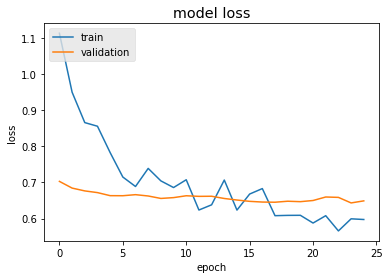

In [26]:
# plotting losses to see if it would have benefitted from more epochs

plot_hist(hist, metric="loss")

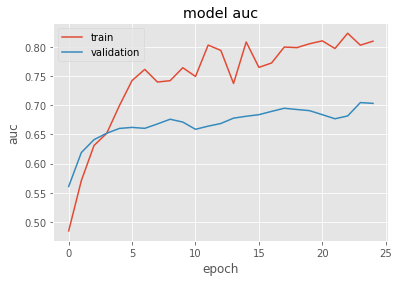

In [27]:
plot_hist(hist, metric="auc")

In [47]:
print(BATCH_SIZE)

32


No. of test images 46
{'M': 0, 'O': 1}


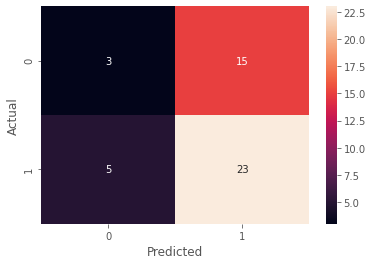

In [28]:
# Checking the performance on testset
testGen.reset()

predIdxs = model_preprocess.predict(x=testGen, 
                                    steps=(totalTest // BATCH_SIZE) + 1
                                    )

predIdxs = np.argmax(predIdxs, axis = 1)
print("No. of test images", len(predIdxs))
print(testGen.class_indices)

cm = confusion_matrix(testGen.classes, predIdxs)

heatmap = sns.heatmap(cm, annot=True)

plt.xlabel("Predicted") 
plt.ylabel("Actual")
plt.show()

In [29]:
def fine_tune_model(model):
    
    # unfreeze last conv block i.e. block7a which can be found in top 20 layers
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
            
    # check which of these are trainable and which aren't
    for layer in model.layers:
	    print("{}: {}".format(layer, layer.trainable))
     
     
    # compile (with an even smaller learning rate)
    opt = Adam(learning_rate=1e-5)
    model.compile(optimizer=opt, 
                loss='binary_crossentropy', 
                metrics=[tf.keras.metrics.AUC()])
    
    return model

In [30]:
model_fine_tuned = fine_tune_model(model_preprocess)


<keras.engine.input_layer.InputLayer object at 0x000002423FA23B20>: False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x0000024269B63190>: False
<keras.layers.preprocessing.normalization.Normalization object at 0x0000024269B632E0>: False
<keras.layers.convolutional.ZeroPadding2D object at 0x0000024269B63970>: False
<keras.layers.convolutional.Conv2D object at 0x0000024269BD68B0>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000024269BD67F0>: False
<keras.layers.core.activation.Activation object at 0x0000024269BF85B0>: False
<keras.layers.convolutional.DepthwiseConv2D object at 0x0000024269C3AFA0>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000024269C7CA90>: False
<keras.layers.core.activation.Activation object at 0x0000024269C7C190>: False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x0000024269C3A4F0>: False
<keras.layers.core.reshape.Reshape object at 0x0000024269C76

In [31]:
# training the model

# Before proceeding with training again, lets reset our train and valgen so that they start with sample #0
trainGen.reset()
valGen.reset()

es_tune = EarlyStopping(monitor='val_loss',  
                   mode='min',  
                   patience=20,  
                   verbose=1  
                   )

mc_tune = ModelCheckpoint('fine_tuned_house.h5', 
                    monitor='val_loss', 
                    mode='min', 
                    verbose=1, 
                    save_best_only=True)

hist = model_fine_tuned.fit(
	x=trainGen,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=valGen,
	epochs=50,
 	verbose=2,
  	callbacks=[es_tune, mc_tune]
  )

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.64890, saving model to fine_tuned_house.h5


C:\Users\seyda\anaconda3\envs\kt\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


10/10 - 113s - loss: 0.6030 - auc_1: 0.8036 - val_loss: 0.6489 - val_auc_1: 0.7044 - 113s/epoch - 11s/step
Epoch 2/50

Epoch 00002: val_loss did not improve from 0.64890
10/10 - 69s - loss: 0.5544 - auc_1: 0.8230 - val_loss: 0.6511 - val_auc_1: 0.7060 - 69s/epoch - 7s/step
Epoch 3/50

Epoch 00003: val_loss did not improve from 0.64890
10/10 - 62s - loss: 0.6365 - auc_1: 0.7978 - val_loss: 0.6529 - val_auc_1: 0.7030 - 62s/epoch - 6s/step
Epoch 4/50

Epoch 00004: val_loss did not improve from 0.64890
10/10 - 59s - loss: 0.5866 - auc_1: 0.8088 - val_loss: 0.6549 - val_auc_1: 0.7030 - 59s/epoch - 6s/step
Epoch 5/50

Epoch 00005: val_loss did not improve from 0.64890
10/10 - 58s - loss: 0.6127 - auc_1: 0.7988 - val_loss: 0.6565 - val_auc_1: 0.7028 - 58s/epoch - 6s/step
Epoch 6/50

Epoch 00006: val_loss did not improve from 0.64890
10/10 - 62s - loss: 0.5964 - auc_1: 0.8062 - val_loss: 0.6581 - val_auc_1: 0.7042 - 62s/epoch - 6s/step
Epoch 7/50

Epoch 00007: val_loss did not improve from 0.6

In [34]:
def plot_hist(hist, metric):
    if metric == 'auc_1':
        plt.plot(hist.history["auc_1"])
        plt.plot(hist.history["val_auc_1"])
    else:
        plt.plot(hist.history["loss"])
        plt.plot(hist.history["val_loss"])
    plt.style.use("ggplot")
    plt.title("model {}".format(metric))
    plt.ylabel("{}".format(metric))
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

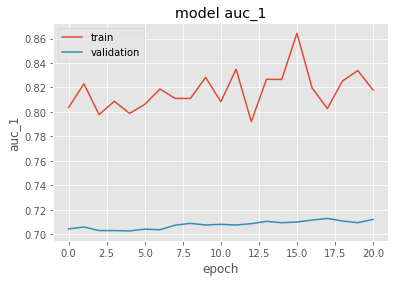

In [35]:
plot_hist(hist, metric="auc_1")

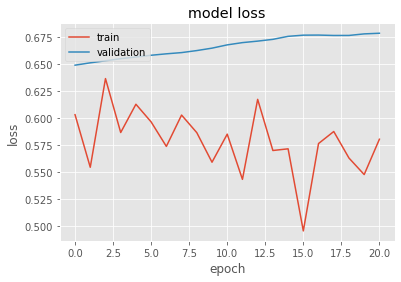

In [36]:
plot_hist(hist, metric="loss")

In [48]:
testGen.reset()

predIdxs = model_fine_tuned.predict(x=testGen)

predIdxs = np.argmax(predIdxs, axis = 1)
len(predIdxs)

46

In [49]:
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))

              precision    recall  f1-score   support

           M       0.55      0.33      0.41        18
           O       0.66      0.82      0.73        28

    accuracy                           0.63        46
   macro avg       0.60      0.58      0.57        46
weighted avg       0.61      0.63      0.61        46



In [50]:
cm = confusion_matrix(testGen.classes, predIdxs)


In [51]:
print(cm)

[[ 6 12]
 [ 5 23]]


{'M': 0, 'O': 1}


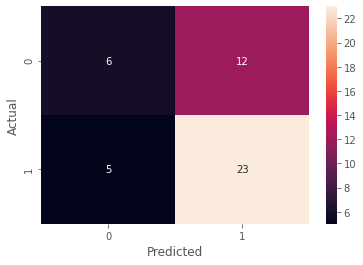

In [52]:
print(testGen.class_indices)

heatmap = sns.heatmap(cm, annot=True)

plt.xlabel("Predicted") 
plt.ylabel("Actual")
plt.show()